In [ ]:
%pip install scikit-learn xgboost matplotlib seaborn

In [4]:
import numpy as np 
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
titanicPath = f"{os.getcwd()}/kaggle/input/titanic"



In [ ]:
dfTreino = pd.read_csv(f"{titanicPath}/train.csv")
dfTreino = dfTreino.set_index('PassengerId')
dfTeste = pd.read_csv(f"{titanicPath}/test.csv")
dfTeste = dfTeste.set_index('PassengerId')

/home/dzr/DEV/KAGGLE/TITANIC


In [6]:
#ENGENHARIA DE ATRIBUTOS
#----Criando a variável Titulo (Pronome de tratamento do passageiro)----
def trazPronome(nomeCompleto, sex):
    #titulos_burgueses = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    titulosPadrao = {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'}
    tit = nomeCompleto.str.extract(r' ([A-Za-z]+)\.', expand=False)
    ret = tit.replace(titulosPadrao) #Padroniza Titulos que significam o mesmo
    #ret = tit.apply(lambda x: "Raro" if x in titulos_burgueses else x) #Padroniza Titulos que são raros em um único grupo
    title_mask = ~ret.isin(['Mr', 'Miss', 'Mrs', 'Master'])
    ret[title_mask] = sex[title_mask].map({'male': 'Mr', 'female': 'Mrs'})
    #df.loc[title_mask, 'Title'] = df.loc[title_mask, 'Sex'].map({'male': 'Mr', 'female': 'Mrs'})
    return ret
def trazFamiliaQtdESozinho(df):
    df['SibSp'] = df['SibSp'].fillna(0)
    df['Parch'] = df['Parch'].fillna(0)
    df['FamiliaQtd'] = df['SibSp'] + df['Parch']
    df['Sozinho'] = (df['FamiliaQtd'] == 0).astype(int) #1 é sozinho, 0 está acompanhado
    return df
    
#----Aplicando as variáveis de Engenharia de Atributos aos dfs Treino e Teste----
dfTreino['Titulo'] = trazPronome(dfTreino['Name'], dfTreino['Sex'])
dfTeste['Titulo'] = trazPronome(dfTeste['Name'], dfTeste['Sex'])
dfTreino = trazFamiliaQtdESozinho(dfTreino)
dfTeste = trazFamiliaQtdESozinho(dfTeste)
#print(dfTreino[['Name', 'Sex', 'Titulo']])
#print(dfTeste[['Name', 'Sex', 'Titulo']])
#print(dfTreino.columns)
#print(dfTeste.columns)

In [7]:
#PRÉ-PROCESSAMENTO
def preProcessar(df, le_dict=None):
    df = df.copy()
#----Idade, quando não presente, preencher com a média de idade para o Titulo em questão----
    title_age_medians = df.groupby('Titulo')['Age'].mean().round(2).to_dict()
    print(title_age_medians)
    for title, median_age in title_age_medians.items():
        age_mask = (df['Age'].isnull()) & (df['Titulo'] == title)
        df.loc[age_mask, 'Age'] = median_age
    df['Age'] = df['Age'].fillna(df['Age'].median())
#----Preço da Passagem, quando não presente, preencher com a média de idade para o Titulo em questão----    
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
#----Porto de Embarque, quando não presente, preencher com o porto mais comum (moda)----
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
#----Com Age normalizado, cria 2 vars auxiliares combinadas, para representar a relação idadexclasse e idadexpassagem
    df['Age*Class'] = df['Age'] * df['Pclass']
    df['Age*Fare'] = df['Age'] * df['Fare']

#----Codificar as categóricas para ints----
    df_sex = pd.get_dummies(df['Sex'], prefix='sex', drop_first=True, dtype=int)
    df_Pclass = pd.get_dummies(df['Pclass'], prefix='class', drop_first=True, dtype=int)
    df_Embarked = pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first=True, dtype=int)
    df_Title = pd.get_dummies(df['Titulo'], prefix='Titulo', drop_first=False, dtype=int)
    df = pd.concat([df, df_sex, df_Pclass, df_Embarked, df_Title], axis=1)

#----Idade e Passagem como variáveis categóricas discretizadas (Bandear: Colocar em bandas/faixas)----
    df['AgeBand'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 60, np.inf], labels=[0, 1, 2, 3, 4])
    df['AgeBand'] = df['AgeBand'].astype(int)
  
    df['FareBand'] = pd.qcut(df['Fare'], q=4, labels=[0, 1, 2, 3])
    df['FareBand'] = df['FareBand'].astype(int)
#----Aplicar função logarítma na Passagem, pois tem muitos valores muito pequenos e alguns valores muito altos (comprime, aproximando da normal)----
    df['Fare_log'] = np.log1p(df['Fare'])
#----Dropa o que não vai precisar----
    df = df.loc[:, ~df.columns.duplicated()] #remove duplicadas
    df = df.drop(['Sex','Pclass','Name','Ticket','Embarked','Cabin', 'Titulo','Fare', 'SibSp', 'Parch'], axis=1)
#----Scaling: Deixa valores numéricos na mesma escala (colunas com números absolutos maiores (pex 0 a 2000), podem dominar colunas de agrupamentos (pex que vão de 0 a 4)----
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    if 'Survived' in numeric_columns:
        numeric_columns = numeric_columns.drop('Survived')# Remover a variável alvo: Deve continuar binária para classificação, e não escalada
    mew = df[numeric_columns].mean(axis=0) #média
    std = df[numeric_columns].std(axis=0) #desvio padrão
    df[numeric_columns] = (df[numeric_columns] - mew) / std #(valor-média)/desvio padrão
    return df

#----Aplicando a função de pré processamento----
    #---Incluindo os mesmod números de encoders
label_cols = ['Sex', 'Embarked', 'Titulo']
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    le.fit(pd.concat([dfTreino[col], dfTeste[col]]))
    le_dict[col] = le
dfTreino = preProcessar(dfTreino, le_dict)
dfTeste = preProcessar(dfTeste, le_dict)
print(dfTreino.head())
print(dfTeste.head())
print(dfTreino.columns)
print(dfTeste.columns)

{'Master': 4.57, 'Miss': 21.85, 'Mr': 32.98, 'Mrs': 35.99}
{'Master': 7.41, 'Miss': 21.77, 'Mr': 32.34, 'Mrs': 38.9}
             Survived       Age  FamiliaQtd   Sozinho  Age*Class  Age*Fare  \
PassengerId                                                                  
1                   0 -0.589331    0.059127 -1.230954   0.026784 -0.473972   
2                   1  0.614758    0.059127 -1.230954  -0.803862  0.930967   
3                   1 -0.288309   -0.560660  0.811467   0.382775 -0.448318   
4                   1  0.388991    0.059127 -1.230954  -0.892860  0.462373   
5                   0  0.388991   -0.560660  0.811467   1.183756 -0.406598   

             sex_male   class_2   class_3  Embarked_Q  Embarked_S  \
PassengerId                                                         
1            0.737281 -0.509865  0.902081    -0.30739    0.615493   
2           -1.354813 -0.509865 -1.107304    -0.30739   -1.622891   
3           -1.354813 -0.509865  0.902081    -0.30739    0.6

In [8]:
#TREINAMENTO
def treinar_modelos(X_train, y_train):
    modelos = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'Logistic': LogisticRegression(max_iter=1000, random_state=42)
    }

    for nome, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        modelos[nome] = modelo

    return modelos

In [9]:
#AVALIAÇÂO DOS MODELOS
def avaliar_modelo(modelo, X_test, y_test, nome_modelo, threshold=0.5):
    y_proba = modelo.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    # ROC e AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{nome_modelo} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Curva ROC - {nome_modelo}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {nome_modelo} (Threshold={threshold})')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

    # Métricas adicionais
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f'\nMétricas para {nome_modelo} (Threshold={threshold}):')
    print(f'AUC: {roc_auc:.4f}')
    print(f'Acurácia: {acc:.4f}')
    print(f'Precisão: {prec:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'Matriz de Confusão:\n{cm}')

    # Importância de Variáveis
    if hasattr(modelo, 'feature_importances_'):
        importancias = modelo.feature_importances_
    elif hasattr(modelo, 'coef_'):
        importancias = modelo.coef_[0]
    else:
        importancias = None

    if importancias is not None:
        plt.figure(figsize=(6, 4))
        sns.barplot(x=importancias, y=X_test.columns)
        plt.title(f'Importância de Variáveis - {nome_modelo}')
        plt.show()

    # Retorno dos valores para comparação posterior
    return {
        'modelo': nome_modelo,
        'AUC': roc_auc,
        'Acurácia': acc,
        'Precisão': prec,
        'Recall': rec,
        'F1-score': f1,
        'Matriz_Confusão': cm
    }


def grafico_correlacao(df):
    df_numerico = df.select_dtypes(include=['int64', 'float64'])  # apenas colunas numéricas
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_numerico.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlação entre Variáveis Numéricas')
    plt.show()

             Survived       Age  FamiliaQtd   Sozinho  Age*Class  Age*Fare  \
PassengerId                                                                  
1                   0 -0.589331    0.059127 -1.230954   0.026784 -0.473972   
2                   1  0.614758    0.059127 -1.230954  -0.803862  0.930967   
3                   1 -0.288309   -0.560660  0.811467   0.382775 -0.448318   
4                   1  0.388991    0.059127 -1.230954  -0.892860  0.462373   
5                   0  0.388991   -0.560660  0.811467   1.183756 -0.406598   

             sex_male   class_2   class_3  Embarked_Q  Embarked_S  \
PassengerId                                                         
1            0.737281 -0.509865  0.902081    -0.30739    0.615493   
2           -1.354813 -0.509865 -1.107304    -0.30739   -1.622891   
3           -1.354813 -0.509865  0.902081    -0.30739    0.615493   
4           -1.354813 -0.509865 -1.107304    -0.30739    0.615493   
5            0.737281 -0.509865  0.9020

/home/dzr/.pyenv/versions/utfpr/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:10:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Avaliação com Threshold = 0.3 ---


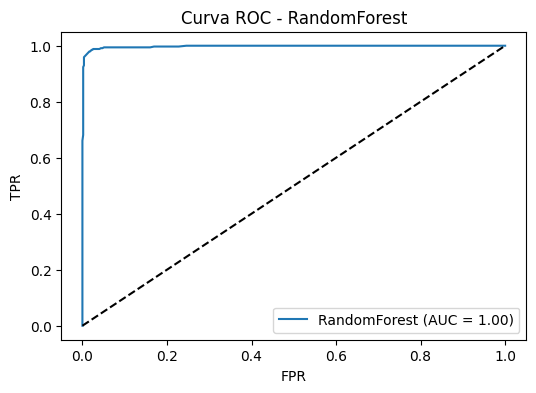

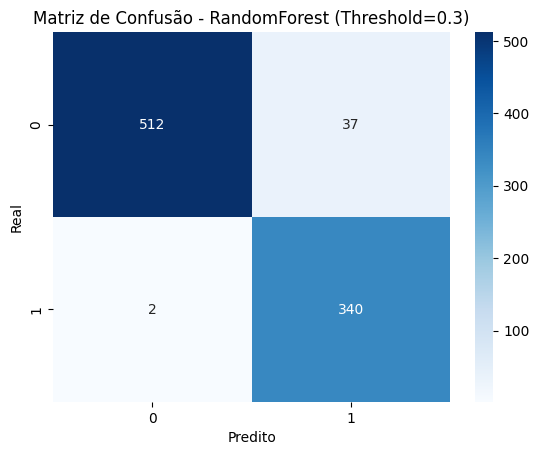


Métricas para RandomForest (Threshold=0.3):
AUC: 0.9976
Acurácia: 0.9562
Precisão: 0.9019
Recall: 0.9942
F1-score: 0.9458
Matriz de Confusão:
[[512  37]
 [  2 340]]


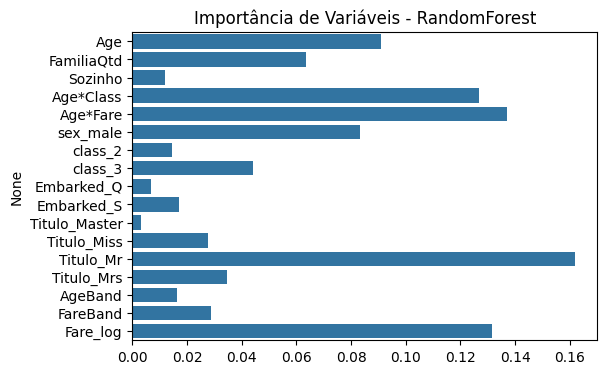

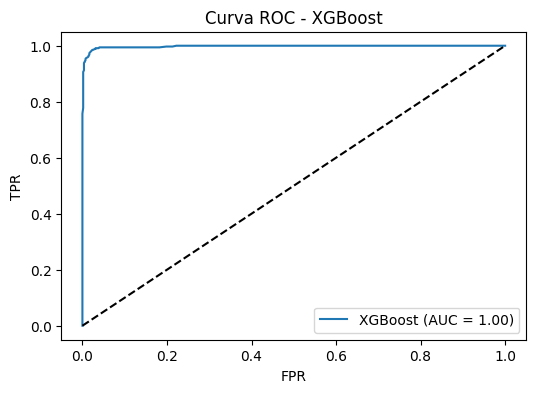

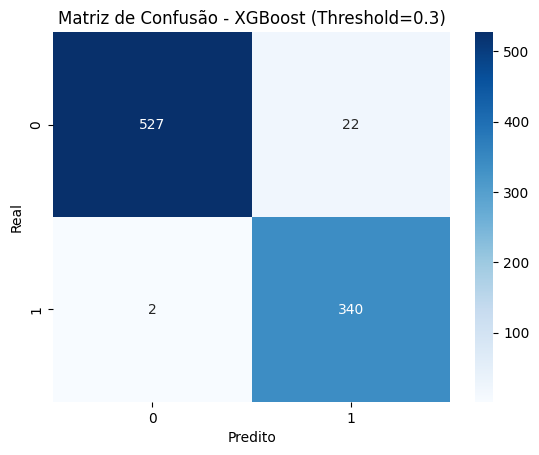


Métricas para XGBoost (Threshold=0.3):
AUC: 0.9976
Acurácia: 0.9731
Precisão: 0.9392
Recall: 0.9942
F1-score: 0.9659
Matriz de Confusão:
[[527  22]
 [  2 340]]


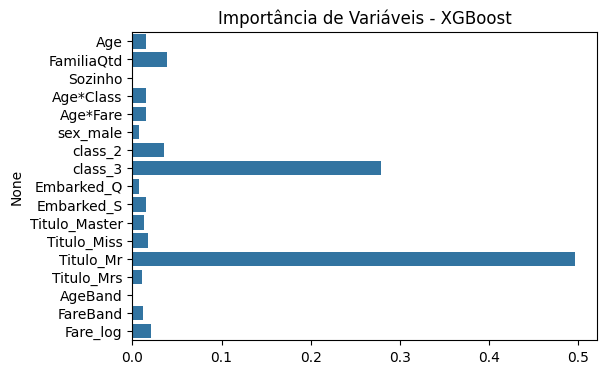

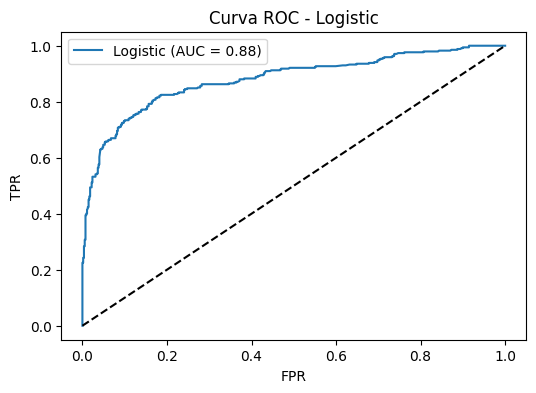

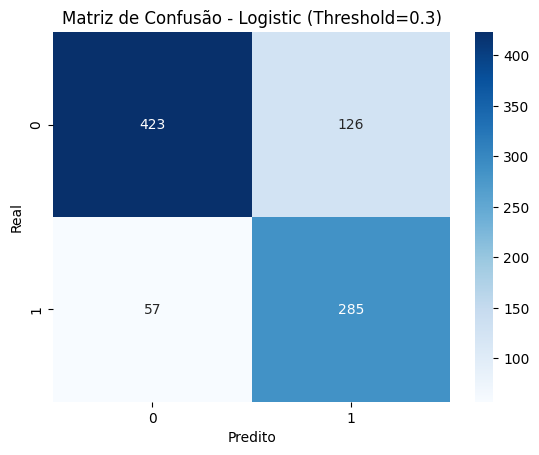


Métricas para Logistic (Threshold=0.3):
AUC: 0.8794
Acurácia: 0.7946
Precisão: 0.6934
Recall: 0.8333
F1-score: 0.7570
Matriz de Confusão:
[[423 126]
 [ 57 285]]


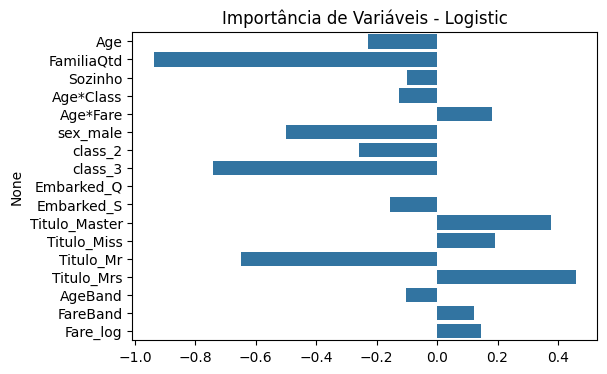


--- Avaliação com Threshold = 0.5 ---


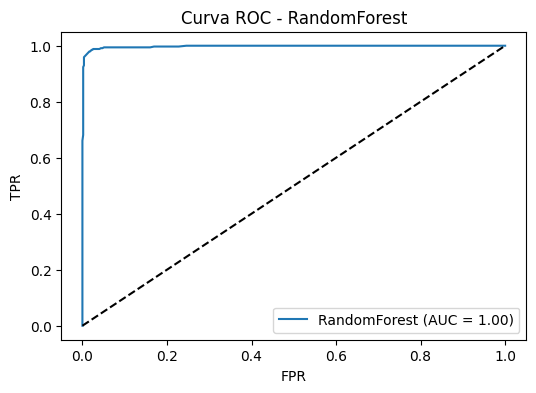

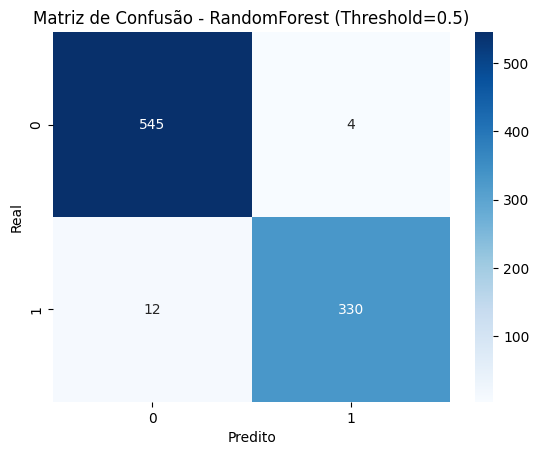


Métricas para RandomForest (Threshold=0.5):
AUC: 0.9976
Acurácia: 0.9820
Precisão: 0.9880
Recall: 0.9649
F1-score: 0.9763
Matriz de Confusão:
[[545   4]
 [ 12 330]]


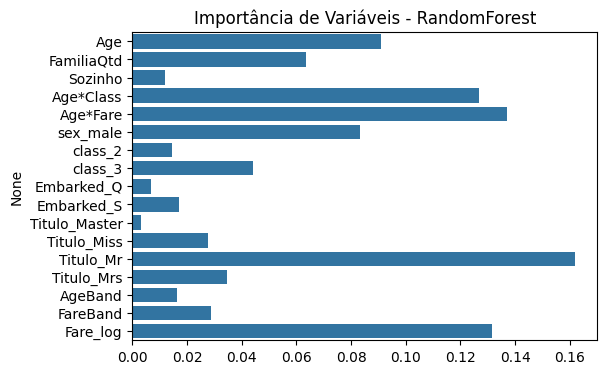

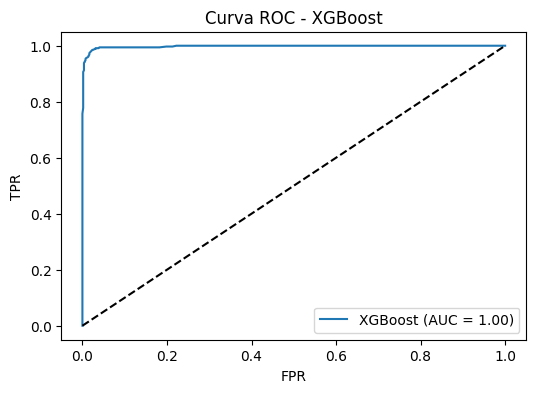

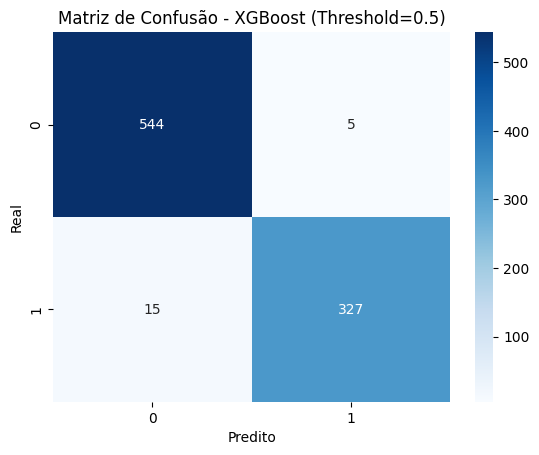


Métricas para XGBoost (Threshold=0.5):
AUC: 0.9976
Acurácia: 0.9776
Precisão: 0.9849
Recall: 0.9561
F1-score: 0.9703
Matriz de Confusão:
[[544   5]
 [ 15 327]]


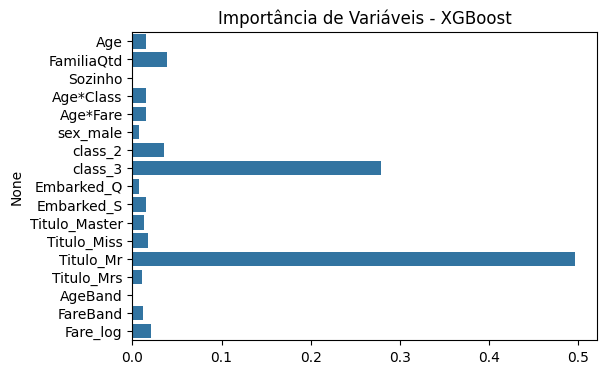

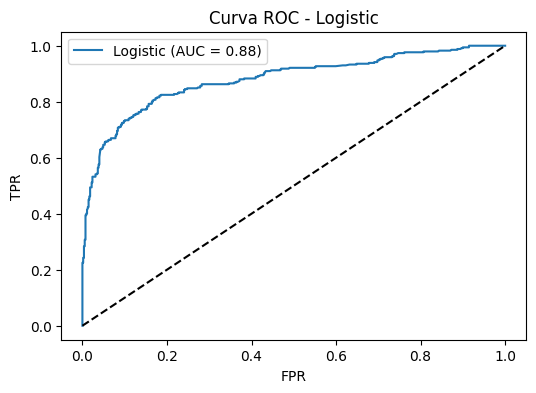

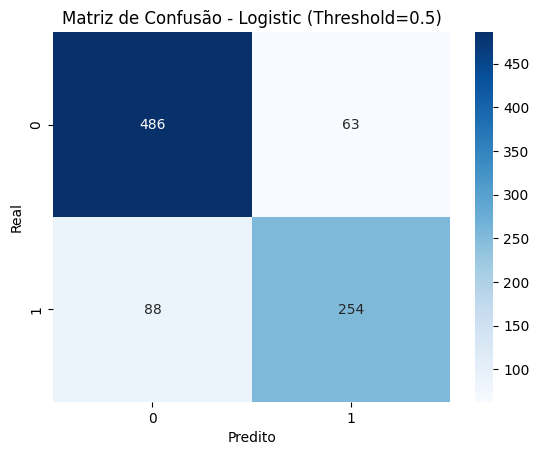


Métricas para Logistic (Threshold=0.5):
AUC: 0.8794
Acurácia: 0.8305
Precisão: 0.8013
Recall: 0.7427
F1-score: 0.7709
Matriz de Confusão:
[[486  63]
 [ 88 254]]


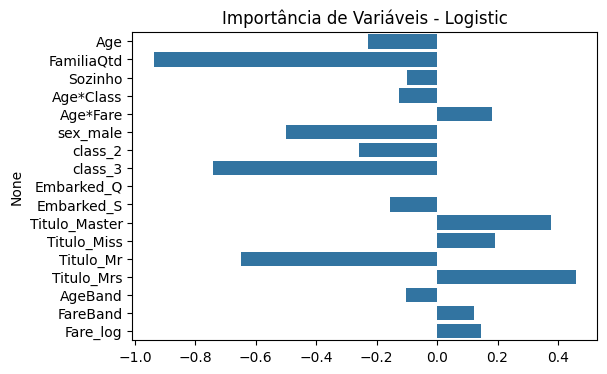


--- Avaliação com Threshold = 0.7 ---


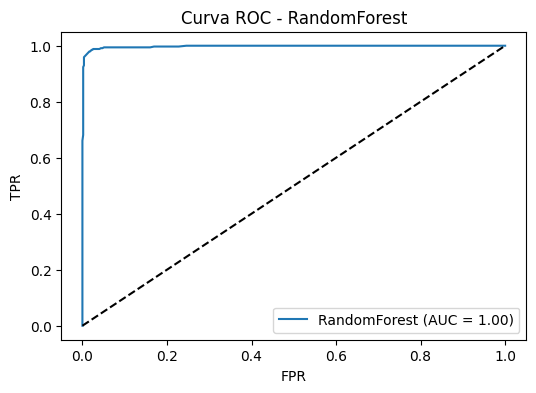

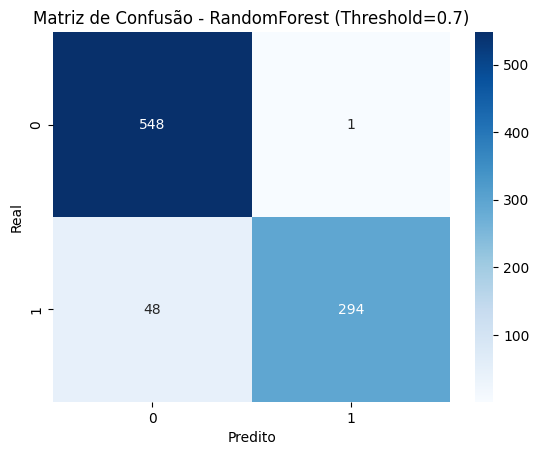


Métricas para RandomForest (Threshold=0.7):
AUC: 0.9976
Acurácia: 0.9450
Precisão: 0.9966
Recall: 0.8596
F1-score: 0.9231
Matriz de Confusão:
[[548   1]
 [ 48 294]]


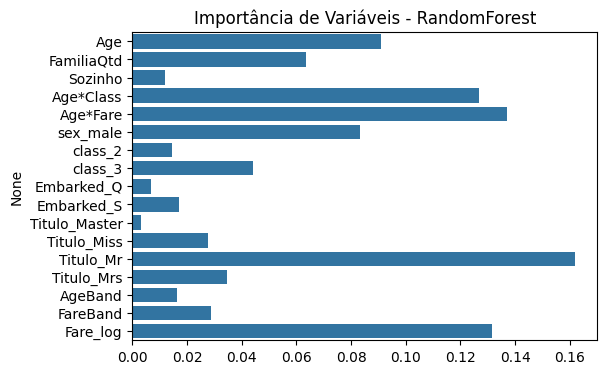

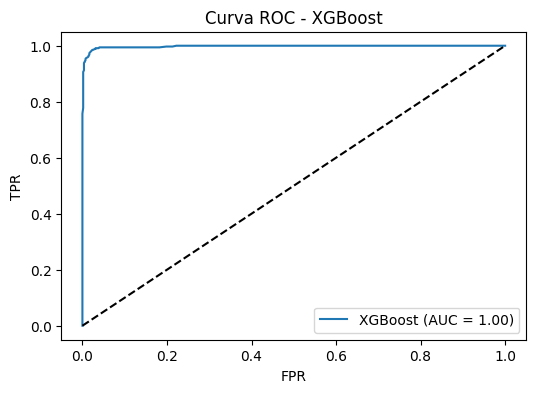

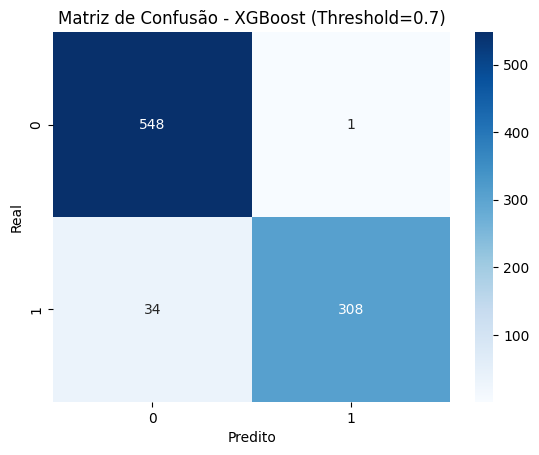


Métricas para XGBoost (Threshold=0.7):
AUC: 0.9976
Acurácia: 0.9607
Precisão: 0.9968
Recall: 0.9006
F1-score: 0.9462
Matriz de Confusão:
[[548   1]
 [ 34 308]]


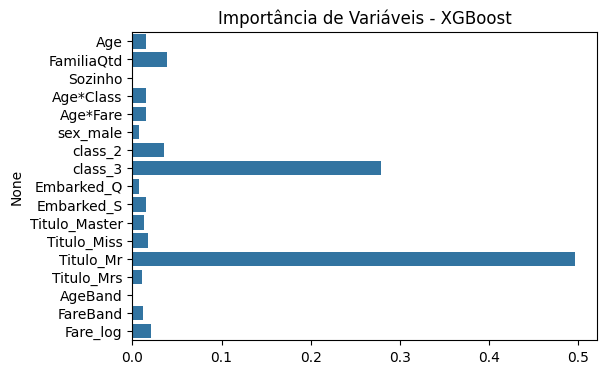

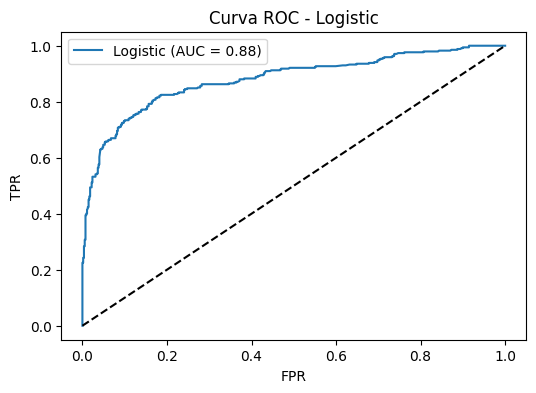

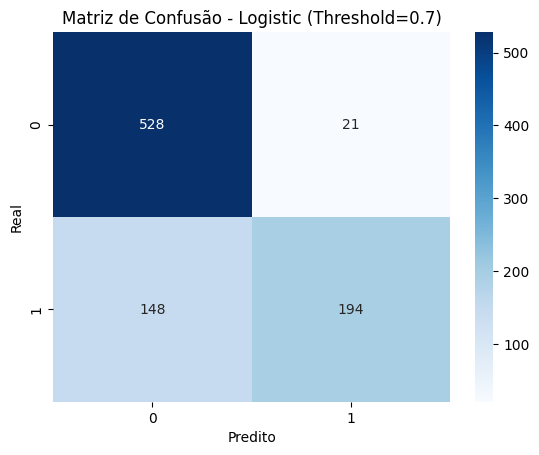


Métricas para Logistic (Threshold=0.7):
AUC: 0.8794
Acurácia: 0.8103
Precisão: 0.9023
Recall: 0.5673
F1-score: 0.6966
Matriz de Confusão:
[[528  21]
 [148 194]]


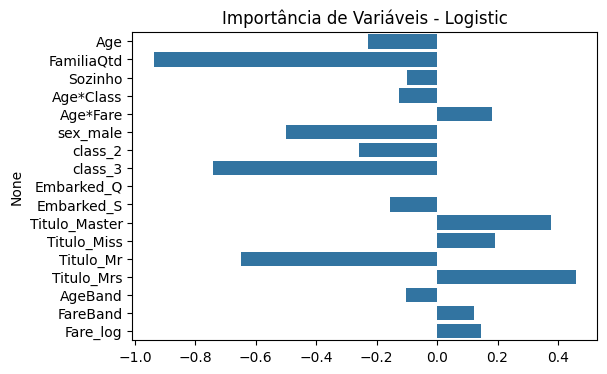

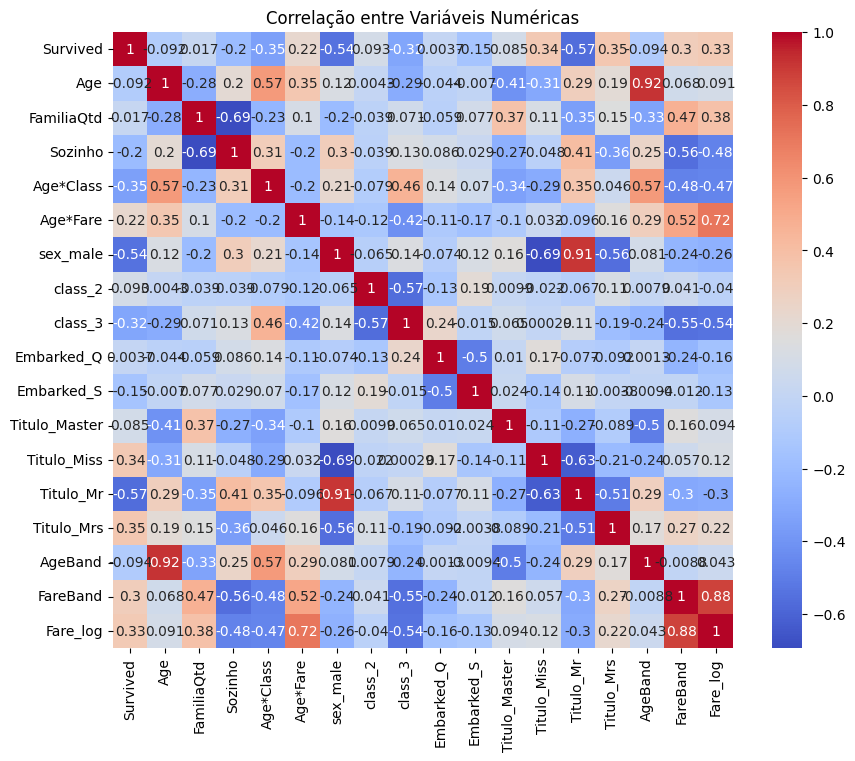

In [10]:
#TREINAMENTO
print(dfTreino.head())
print(dfTeste.head())
#----Separar variáveis----
X_train = dfTreino.copy()
X_train = X_train.drop(columns=['Survived'])
y_train = dfTreino['Survived']
X_test = dfTeste.copy()
#----Treinar os 3 tipos de modelos----
modelos = treinar_modelos(X_train, y_train)
#----Avaliar os modelos----
thresholds = [0.3, 0.5, 0.7]
for threshold in thresholds:
    print(f'\n--- Avaliação com Threshold = {threshold} ---')
    for nome, modelo in modelos.items():
        resultado = avaliar_modelo(modelo, X_train, y_train, nome_modelo=nome, threshold=threshold)
# Correlação
grafico_correlacao(dfTreino)

In [11]:
#INFERÊNCIA
#----Seleciona o modelo escolhido após avaliar_modelo (RandomForest)----
modelo_rf = modelos['RandomForest']
#----Gera probabilidades----
y_proba = modelo_rf.predict_proba(X_test)[:, 1]
# Aplicar threshold
threshold = 0.5
predictions = (y_proba >= threshold).astype(int)
output = pd.DataFrame({
    'PassengerId': dfTeste.index,
    'Survived': predictions
})

output.to_csv('submission.csv', index=False)
#dfsubm = pd.read_csv('submission.csv')
#print(dfsubm)

